# Adversarial Neural Network for Decorrelated Jet Classification

This section introduces an Adversarial Neural Network (ANN) architecture designed to perform jet classification while reducing correlation with jet mass and transverse momentum (p<sub>T</sub>). The approach aims to preserve classification performance while mitigating biases that can lead to sculpted backgrounds in physical observables.

The network includes:

A classifier (discriminator) trained to distinguish QCD from Higgs jets.

A regressor (adversary) trained to predict jet mass and p<sub>T</sub>.

During joint training, the adversary's loss is negatively weighted, encouraging the classifier to learn features that are independent of mass and p<sub>T</sub>.

The model is pretrained in two stages (classifier and adversary) before adversarial training begins. All jets are selected within:

Mass window: 40 GeV < M<sub>sd</sub> < 200 GeV

p<sub>T</sub> range: 300 GeV < p<sub>T</sub> < 2000 GeV

Performance is assessed using the ROC curve and AUC metric, with special attention paid to how well the classifier resists overfitting to kinematic variables.

In [1]:
# ================================
# Core Libraries
# ================================
import numpy as np                      # Numerical operations
import yaml                             # Reading YAML configuration files

# ================================
# ROOT File Handling
# ================================
import uproot                           # Reading ROOT files in Python (no need for ROOT C++)
import fsspec_xrootd                    # Enables uproot to read files over XRootD (e.g., from EOS)

# ================================
# Custom Utilities
# ================================
from utilities.deepset_adversarial_datagenerator import DataGenerator  # Custom data generator for DeepSet with adversarial training

# ================================
# Plotting and Visualization
# ================================
import matplotlib.pyplot as plt         # Standard plotting library
import mplhep as hep                    # High Energy Physics (HEP) style plotting (CMS, ATLAS, etc.)
plt.style.use(hep.style.ROOT)           # Use ROOT-style for consistency with HEP plots

# ================================
# TensorFlow / Keras for Deep Learning
# ================================
import tensorflow as tf
import tensorflow.keras as keras

# Keras Functional API for defining models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, 
    GlobalAveragePooling1D, Dropout, Flatten
)

# Keras Callbacks for better training control
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

# Backend utilities (for advanced loss functions, etc.)
import tensorflow.keras.backend as K

# ================================
# Evaluation Metrics
# ================================
from sklearn.metrics import roc_curve, auc  # For ROC curve and AUC score calculation


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Running on:", tf.config.list_physical_devices())

Running on: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
with open('./utilities/definitions_gnn_deepset_adversarial.yml', 'r') as file:
    definitions = yaml.load(file, Loader = yaml.FullLoader)

features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

In [4]:
# ========================================
# File paths for training, validation, and testing datasets
# ========================================
train_files = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_10.root']
val_files   = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_11.root']
test_files  = ['/Users/sashibhusansahoo/Desktop/iop sem 1/Project Stuff/root_data/ntuple_merged_0.root']

# Batch size used for all datasets
batch_size = 1024

# ========================================
# Training Data Generator
# ========================================
train_generator = DataGenerator(
    train_files,             # List of ROOT files for training
    features,                # Input feature list (from YAML)
    labels,                  # Output label list (from YAML)
    spectators,              # Spectator variables (e.g., mass, pt)
    batch_size=batch_size,   # Number of events per batch
    n_dim=ntracks,           # Max number of tracks per jet
    remove_mass_pt_window=True,     # Apply mass/pT filtering [40 < mass < 200, 300 < pt < 2000]
    remove_unlabeled=True,          # Remove samples without clear label (signal or background)
    return_spectators=True,         # Also return spectator variables in the output
    max_entry=1000,                 # Max events to read per file
    scale_mass_pt=[100.0, 10000.0]  # Normalization factors for mass and pt
)

# ========================================
# Validation Data Generator
# ========================================
val_generator = DataGenerator(
    val_files,
    features,
    labels,
    spectators,
    batch_size=batch_size,
    n_dim=ntracks,
    remove_mass_pt_window=True,
    remove_unlabeled=True,
    return_spectators=True,
    max_entry=200,
    scale_mass_pt=[100.0, 10000.0]
)

# ========================================
# Test Data Generator
# ========================================
test_generator = DataGenerator(
    test_files,
    features,
    labels,
    spectators,
    batch_size=batch_size,
    n_dim=ntracks,
    remove_mass_pt_window=True,
    remove_unlabeled=True,
    return_spectators=True,
    max_entry=400,
    # Note: scale_mass_pt is omitted here; will default to [1, 1] unless handled inside DataGenerator
)

In [5]:
# ======================================
# Define Deep Sets Discriminator Model
# ======================================

# Input layer: shape = (number of tracks, number of features per track)
inputs = Input(shape=(ntracks, nfeatures), name='input')

# Per-track feature transformation layers
x = BatchNormalization(name='bn1')(inputs)              # Normalize features
x = Dense(64, activation='relu', name='dense_1')(x)     # First dense layer
x = Dense(32, activation='relu', name='dense_2')(x)     # Second dense layer
x = Dense(32, activation='relu', name='dense_3')(x)     # Third dense layer

# Pool across all tracks (Deep Sets symmetry function)
x = GlobalAveragePooling1D(name='pool_1')(x)

# Final classification layers
x = Dense(100, activation='relu', name='dense_4')(x)
outputs = Dense(nlabels, activation='softmax', name='output')(x)  # Classifier output

# Construct and compile discriminator model
keras_model_disc = Model(inputs=inputs, outputs=outputs)
keras_model_disc.compile(optimizer='adam', loss='categorical_crossentropy')

# ======================================
# Define Adversarial Regressor Model
# ======================================

# Use output of discriminator as input to the regressor
x = Dense(100, activation='relu', name='dense_5')(keras_model_disc(inputs))  # First regressor layer
x = Dense(100, activation='relu', name='dense_6')(x)                         # Second regressor layer
output_reg = Dense(2, activation='linear', name='mass_pt_reg')(x)           # Output layer: mass and pT

# Construct and compile regressor model
sgd_opt = keras.optimizers.SGD(momentum=0.0)
keras_model_reg = Model(inputs=inputs, outputs=output_reg)
keras_model_reg.compile(optimizer=sgd_opt, loss='mse')

# ======================================
# Combine Models into Adversarial Setup
# ======================================

# Combine discriminator and regressor into a single adversarial model
# Loss weights: [classifier loss, -λ × regression loss]
lam = 1  # λ controls adversarial strength (try tuning this)
keras_model_adv = Model(inputs=inputs, outputs=[keras_model_disc(inputs), keras_model_reg(inputs)])
keras_model_adv.compile(
    optimizer=sgd_opt,
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[1, -lam]
)

# ======================================
# Print Model Summaries
# ======================================
keras_model_disc.summary()   # Discriminator model (signal vs. background)
keras_model_reg.summary()    # Regressor model (mass & pT prediction)
keras_model_adv.summary()    # Combined adversarial model

2025-07-11 12:07:23.390507: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-07-11 12:07:23.390527: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-11 12:07:23.390531: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-11 12:07:23.390545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-11 12:07:23.390552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 74)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 60, 74)         │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60, 64)         │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (GlobalAveragePooling1D) │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │         3,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,734 (45.84 KB)

 Trainable params: 11,586 (45.26 KB)

 Non-trainable params: 148 (592.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 60, 74)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 2)              │        11,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mass_pt_reg (Dense)             │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,336 (87.25 KB)

 Trainable params: 22,188 (86.67 KB)

 Non-trainable params: 148 (592.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 74)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 2)         │     11,734 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 2)         │     22,336 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,336 (87.25 KB)

 Trainable params: 22,188 (86.67 KB)

 Non-trainable params: 148 (592.00 B)

In [6]:
# ======================================
# Step 1: Pretrain Discriminator (Deep Sets Classifier)
# ======================================

# Make sure the classifier is trainable
keras_model_disc.trainable = True

# Re-compile to apply the trainable flag
keras_model_disc.compile(optimizer='adam', loss='categorical_crossentropy')

# Loop over epochs and batches
for epoch in range(20):
    for i, t in enumerate(train_generator):
        if t is None:
            break  # Skip empty batches
        else:
            # Train only on classification labels (t[1][0] → class label)
            keras_model_disc.fit(t[0], t[1][0], verbose=0)


# ======================================
# Step 2: Pretrain Regressor (Adversary)
# ======================================

# Allow regressor to train, freeze classifier
keras_model_reg.trainable = True
keras_model_disc.trainable = False

# Re-compile regressor with SGD optimizer
keras_model_reg.compile(optimizer=sgd_opt, loss='mse')

# Loop over epochs and batches
for epoch in range(20):
    for i, t in enumerate(train_generator):
        if t is None:
            break  # Skip empty batches
        else:
            # Regress on classifier outputs (this is likely incorrect — see note below)
            keras_model_reg.fit(t[0], t[1][0], verbose=0)

2025-07-11 12:07:32.382045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [7]:
# Save the model and the weights
keras_model_adv.save_weights('./trained_models/new_models/keras_model_best_adversarial_weights.weights.h5')

keras_model_adv.save('./trained_models/new_models/keras_model_best_adversarial.keras')

In [8]:
# ============================================
# Evaluate Adversarial Model on Test Dataset
# ============================================

# Initialize empty lists to store:
# - predictions from the adversarial model
# - true labels (for classification)
# - spectator variables (mass, pt)
predict_array_adv = []
label_array_test = []
spec_array_test = []


# Loop over test batches
for i, t in enumerate(test_generator):
    if t is None:
        break  # Skip if batch is empty
    else:
        # Store classification labels (y)
        label_array_test.append(t[1][0])

        # Store spectator variables (e.g. mass, pt)
        spec_array_test.append(t[1][1])

        # Get predictions from adversarial model
        # keras_model_adv.predict(...) returns [classifier_output, regressor_output]
        # Here we only care about classifier output → index 0
        predict_array_adv.append(keras_model_adv.predict(t[0])[0])


# Concatenate all stored outputs from each batch
predict_array_adv = np.concatenate(predict_array_adv, axis=0)     # Predicted class probabilities
label_array_test  = np.concatenate(label_array_test, axis=0)      # True class labels
spec_array_test   = np.concatenate(spec_array_test, axis=0)       # Spectator variables (mass, pt)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


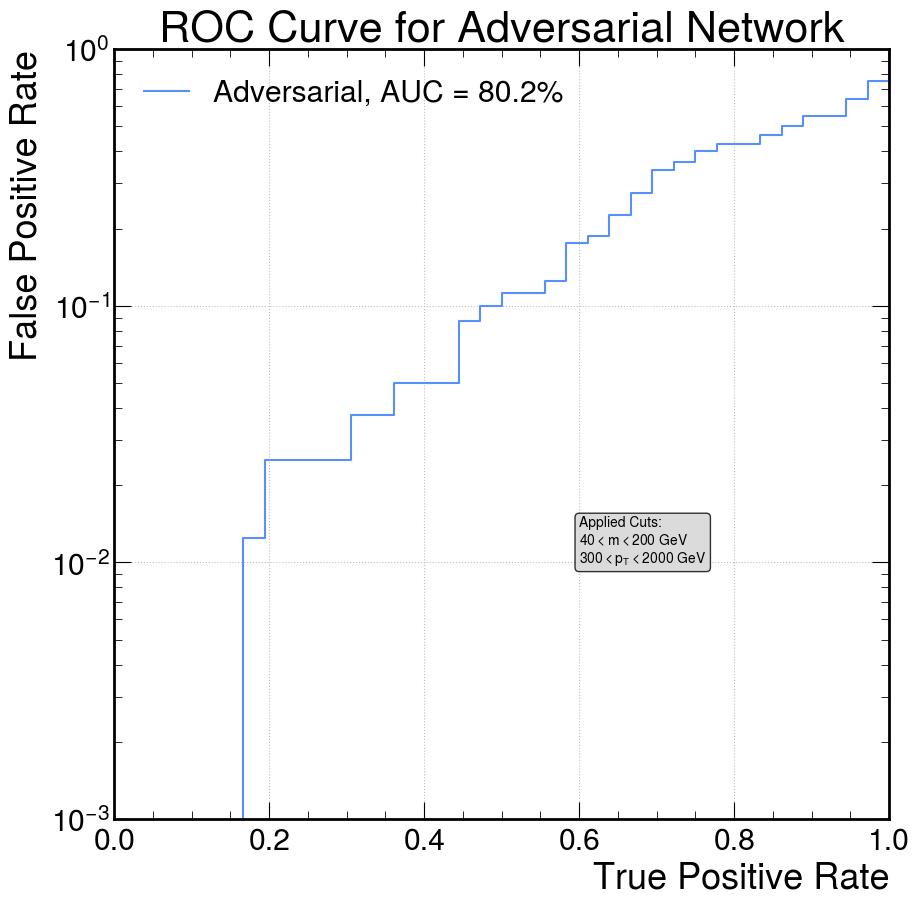

In [9]:
# ===========================================================
# Compute ROC Curve and AUC Score for Adversarial Classifier
# ===========================================================
fpr_adv, tpr_adv, threshold_adv = roc_curve(label_array_test[:, 1], predict_array_adv[:, 1])
auc_adv = auc(fpr_adv, tpr_adv)

# ===========================
# Plot ROC Curve with Cuts Box
# ===========================
plt.figure()

# Plot the ROC curve
plt.plot(tpr_adv, fpr_adv, label=f"Adversarial, AUC = {auc_adv*100:.1f}%")

# Axis labels and formatting
plt.xlabel(r'True Positive Rate')
plt.ylabel(r'False Positive Rate')
plt.semilogy()
plt.xlim(0, 1)
plt.ylim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.title('ROC Curve for Adversarial Network')

# ===========================
# Add a Box Showing Cuts
# ===========================

# Text box content
cut_text = (
    "Applied Cuts:\n"
    r"$40 < m < 200$ GeV" "\n"
    r"$300 < p_T < 2000$ GeV"
)

# Add the annotation box to the plot
plt.gca().text(
    0.6,              # x position (in axis fraction)
    0.01,             # y position (in axis fraction for log scale)
    cut_text,
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="lightgray", edgecolor="black", alpha=0.8)
)

# Show the plot
plt.show()
